In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: unzip /content/drive/MyDrive/Spring Final Project/dataset.zip into 'content/dataset'

!unzip "/content/drive/MyDrive/Spring Final Project/dataset.zip"


Archive:  /content/drive/MyDrive/Spring Final Project/dataset.zip
  inflating: dataset/Removed Images.txt  
   creating: dataset/testing/
   creating: dataset/testing/elevation/
  inflating: dataset/testing/elevation/Area_1_elevation_10.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_103.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_109.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_110.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_120.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_126.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_127.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_142.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_144.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_146.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_147.tif  
  inflating: dataset/testing/elevation/Area_1_elevation_159.tif  
  inflating: dataset/testing/el

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 40.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms
from PIL import Image
import cv2
import rasterio
from torchvision.transforms import Resize

class SingleBuildingDamageDataset(Dataset):
    def __init__(self, dataset_dir, square_size=50, transform=None):
        self.dataset_dir = dataset_dir
        self.square_size = square_size
        self.transform = transform
        self.data = []

        post_image_paths = sorted(os.listdir(os.path.join(dataset_dir, 'post_img')))
        pre_mask_paths = sorted(os.listdir(os.path.join(dataset_dir, 'pre_msk')))
        pde_label_paths = sorted(os.listdir(os.path.join(dataset_dir, 'PDE_labels')))
        elevation_paths = sorted(os.listdir(os.path.join(dataset_dir, 'elevation')))
        hand_paths = sorted(os.listdir(os.path.join(dataset_dir, 'hand')))
        imperviousness_paths = sorted(os.listdir(os.path.join(dataset_dir, 'imperviousness')))

        resize_transform = Resize((360, 360))

        for idx in range(len(post_image_paths)):
            post_img_path = os.path.join(self.dataset_dir, 'post_img', post_image_paths[idx])
            pre_mask_path = os.path.join(self.dataset_dir, 'pre_msk', pre_mask_paths[idx])
            pde_label_path = os.path.join(self.dataset_dir, 'PDE_labels', pde_label_paths[idx])
            elevation_path = os.path.join(self.dataset_dir, 'elevation', elevation_paths[idx])
            hand_path = os.path.join(self.dataset_dir, 'hand', hand_paths[idx])
            imperviousness_path = os.path.join(self.dataset_dir, 'imperviousness', imperviousness_paths[idx])

            # Load and resize images and masks
            post_image = resize_transform(Image.open(post_img_path).convert('RGB'))
            pre_mask = resize_transform(Image.open(pre_mask_path).convert('L'))
            pde_label = resize_transform(Image.open(pde_label_path).convert('L'))

            with rasterio.open(elevation_path) as elevation_src, \
                 rasterio.open(hand_path) as hand_src, \
                 rasterio.open(imperviousness_path) as imperviousness_src:
                elevation_band = elevation_src.read(1)
                elevation_img = Image.fromarray(elevation_band)
                elevation_img = resize_transform(elevation_img)

                hand_band = hand_src.read(1)
                hand_img = Image.fromarray(hand_band)
                hand_img = resize_transform(hand_img)

                imperviousness_band = imperviousness_src.read(1)
                imperviousness_img = Image.fromarray(imperviousness_band)
                imperviousness_img = resize_transform(imperviousness_img)

            pre_mask_np = np.array(pre_mask)
            pre_mask_np = np.where(pre_mask_np < 100, 0, 255).astype(np.uint8)
            contours, _ = cv2.findContours(pre_mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                cropped_data = self.crop_layers(contour, np.array(post_image), np.array(elevation_img), np.array(hand_img), np.array(imperviousness_img))
                if cropped_data:
                    building, elevation, hand, imperviousness = cropped_data
                    damage_level = self.get_damage_level(contour, np.array(pde_label))
                    if self.transform:
                        building = self.transform(TF.to_pil_image(building))

                    elevation_channel = TF.to_tensor(elevation)
                    hand_channel = TF.to_tensor(hand)
                    imperviousness_channel = TF.to_tensor(imperviousness)

                    six_channel_image = torch.cat((building, elevation_channel, hand_channel, imperviousness_channel), dim=0)

                    self.data.append((six_channel_image, damage_level))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        six_channel_image, damage_level = self.data[idx]
        return six_channel_image, damage_level

    def crop_layers(self, contour, post_image, elevation, hand, imperviousness):
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2

        top_left_x = max(center_x - self.square_size // 2, 0)
        top_left_y = max(center_y - self.square_size // 2, 0)
        bottom_right_x = min(top_left_x + self.square_size, post_image.shape[1])
        bottom_right_y = min(top_left_y + self.square_size, post_image.shape[0])

        if bottom_right_x - top_left_x == self.square_size and bottom_right_y - top_left_y == self.square_size:
            return (
                post_image[top_left_y:bottom_right_y, top_left_x:bottom_right_x],
                elevation[top_left_y:bottom_right_y, top_left_x:bottom_right_x],
                hand[top_left_y:bottom_right_y, top_left_x:bottom_right_x],
                imperviousness[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            )
        return None

    def get_damage_level(self, contour, pde_label):
        x, y, w, h = cv2.boundingRect(contour)
        center_x, center_y = x + w // 2, y + h // 2

        top_left_x = max(center_x - self.square_size // 2, 0)
        top_left_y = max(center_y - self.square_size // 2, 0)
        bottom_right_x = min(top_left_x + self.square_size, pde_label.shape[1])
        bottom_right_y = min(top_left_y + self.square_size, pde_label.shape[0])

        cropped_pde_label = pde_label[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
        filtered_labels = cropped_pde_label[cropped_pde_label != 4]
        if filtered_labels.size > 0:
            unique, counts = np.unique(filtered_labels, return_counts=True)
            return torch.tensor(unique[np.argmax(counts)], dtype=torch.long)
        return torch.tensor(255, dtype=torch.long)  # Placeholder for undetermined or no damage


In [ ]:


from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = SingleBuildingDamageDataset('dataset/training', square_size=80, transform=transform)




In [ ]:
import torch.nn as nn
import torchvision.models as models

def adapt_vgg_to_six_channels(vgg_model, num_classes=4, init_method=None):
    # Modify the first convolutional layer to accept 6 channels
    original_first_layer = vgg_model.features[0]
    new_first_layer = nn.Conv2d(6, original_first_layer.out_channels, kernel_size=original_first_layer.kernel_size,
                                stride=original_first_layer.stride, padding=original_first_layer.padding)
    if init_method == "copy":
        with torch.no_grad():
            # Copy weights for the first 3 channels from the pre-trained model, initialize the rest
            new_first_layer.weight[:, :3] = original_first_layer.weight.clone()
            nn.init.constant_(new_first_layer.weight[:, 3:], 0.01)  # Initialize the new channels
    vgg_model.features[0] = new_first_layer

    # Adjust the final classifier layer to output 4 classes
    num_features = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_features, num_classes)

    return vgg_model

In [ ]:
from torch.utils.data import DataLoader, random_split

# Assume adapt_vgg_to_six_channels is defined as discussed
vgg16_adapted = models.vgg16(pretrained=False)  # Start without pretrained weights
vgg16_adapted = adapt_vgg_to_six_channels(vgg16_adapted, num_classes=4, init_method="copy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16_adapted = vgg16_adapted.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
val_percent = 0.2  # 20% of the dataset for validation
num_val = int(len(dataset) * val_percent)
num_train = len(dataset) - num_val
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])
batch_size = 16  # Adjust based on your GPU memory

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


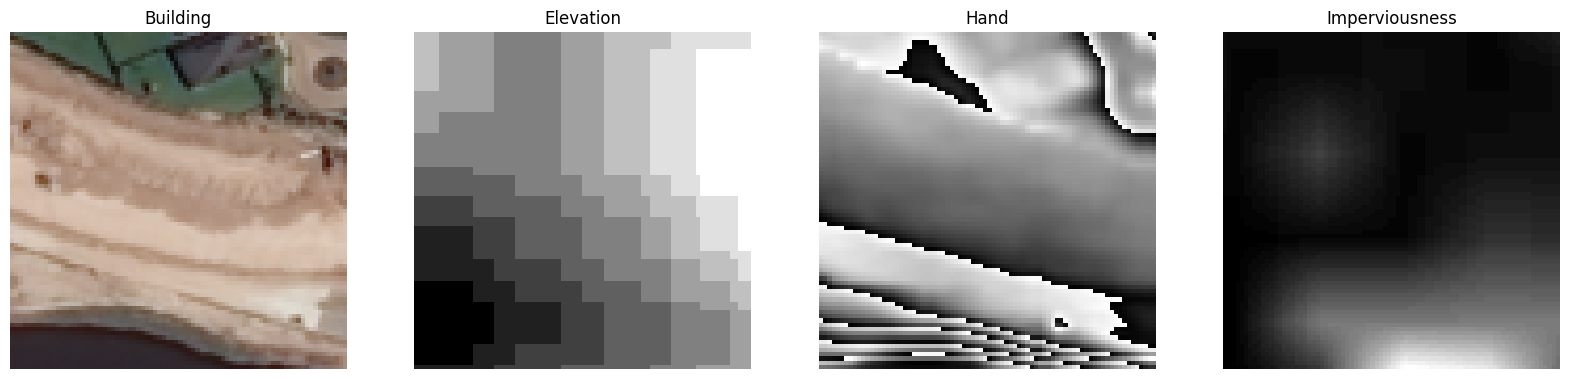

In [ ]:
import matplotlib.pyplot as plt
def denormalize(tensor, mean, std):
    """Denormalizes a tensor using the given mean and std."""
    denorm = tensor.clone()
    for t, m, s in zip(denorm, mean, std):
        t.mul_(s).add_(m)  # Reverse of the normalization equation
    return denorm

def show_sample(data, index):
    """
    Display the denormalized building image and each channel (elevation, hand, imperviousness) for a given index.
    """
    # Retrieve the six-channel image and damage level
    six_channel_image, damage_level= data[index]

    # Assuming the first 3 channels are building (RGB), followed by elevation, hand, and imperviousness
    building_img = six_channel_image[:3, :, :]
    elevation_channel = six_channel_image[3, :, :].unsqueeze(0)
    hand_channel = six_channel_image[4, :, :].unsqueeze(0)
    imperviousness_channel = six_channel_image[5, :, :].unsqueeze(0)

    # Denormalize the building image
    mean = [0.485, 0.456, 0.406]  # Adjust these values to match those used during normalization
    std = [0.229, 0.224, 0.225]   # Adjust these values to match those used during normalization
    building_img_denorm = denormalize(building_img, mean, std)
    building_img_pil = TF.to_pil_image(building_img_denorm)

    # Convert single-channel images to PIL images for display
    elevation_img_pil = TF.to_pil_image(elevation_channel)
    hand_img_pil = TF.to_pil_image(hand_channel)
    imperviousness_img_pil = TF.to_pil_image(imperviousness_channel)

    # Create subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(building_img_pil)
    axs[0].set_title('Building')
    axs[0].axis('off')

    axs[1].imshow(elevation_img_pil, cmap='gray')
    axs[1].set_title('Elevation')
    axs[1].axis('off')

    axs[2].imshow(hand_img_pil, cmap='gray')
    axs[2].set_title('Hand')
    axs[2].axis('off')

    axs[3].imshow(imperviousness_img_pil, cmap='gray')
    axs[3].set_title('Imperviousness')
    axs[3].axis('off')

    plt.show()



show_sample(dataset, 69)


In [ ]:
vgg16_adapted.train()  # Set the model to evaluation mode
with torch.no_grad():
    for inputs, _ in train_dataloader:
        inputs = inputs.to(device)
        outputs = vgg16_adapted(inputs)
        print(outputs)
        _, predicted = torch.max(outputs, 1)
        print("Predicted labels:", predicted.cpu().numpy())

        break  # Just testing with one batch


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


tensor([[-1.0198e+00, -3.6534e-01,  2.2421e-01,  1.7119e-01],
        [-6.0712e-01, -1.0368e+00, -5.3855e-01,  1.9773e+00],
        [-6.7726e-01, -1.3511e+00, -4.9853e-01, -1.0978e-01],
        [-7.1984e-01, -1.5115e+00, -2.6940e-01, -5.4637e-01],
        [-6.2223e-01, -8.8512e-01, -7.7209e-01,  9.9398e-01],
        [-3.2745e-01,  7.1774e-01, -4.8989e-01,  9.7289e-01],
        [-7.7605e-01, -1.1539e+00,  1.9752e-01,  1.2381e+00],
        [-7.4025e-01,  1.4102e-01, -3.7441e-01, -1.8678e-02],
        [-1.9530e-01, -5.3714e-01, -9.0260e-01,  7.8716e-02],
        [ 2.0267e-01, -1.4821e+00, -1.6214e-01, -5.2441e-01],
        [-4.0721e-01, -3.4850e-01,  2.4270e-01, -7.6591e-02],
        [-2.0019e-03,  1.1418e-02,  1.6102e-01, -8.9947e-01],
        [ 6.2694e-01, -9.8042e-01, -6.9802e-01,  5.3287e-01],
        [-1.0059e+00,  3.9992e-02, -8.1795e-01, -9.3459e-01],
        [-2.5333e+34, -7.1064e+34, -3.8930e+34,  5.6594e+33],
        [-1.7359e+00,  2.0183e-01,  2.8573e-01,  2.3286e-01]], device=

In [ ]:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16_adapted.parameters(), lr=0.001)

def train_and_validate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_dataloader)}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        print(f'Epoch {epoch+1}, Validation Loss: {val_running_loss / len(val_dataloader)}')


train_and_validate(vgg16_adapted, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)


Streaming output truncated to the last 5000 lines.
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted labels: tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], device='cuda:0', grad_fn=<AddmmBackward0>)
Predicted labels: tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, n

KeyboardInterrupt: 